# Repulsion

## Test Input

```python
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from ase.build import molecule
from ase_interface import SCME_PS

# Make H2O molecule with experimental bond lengths.
# (tag = 1)
atoms = molecule("H2O")
atoms.cell = [10, 10, 10]
atoms.pbc = True
atoms.translate([0, 0, 5])
atoms.set_tags(1)

# Add second water molecules. (tag = 0)
atoms += molecule("H2O")

#view(atoms)

# Add SCME calculator.
atoms.calc = SCME_PS(atoms)

# Results list holds O-O distance and corresponding E_vdw.
results = []

# Vary the positions of one molecule.
mol_idx = [atom.index for atom in atoms if atom.tag == 1]
for i in range(500):

    # Adjust positions.
    pos = atoms.get_positions()
    pos[mol_idx] += [0, 0, 0.1]
    atoms.set_positions(pos)

    # Calculate O-O distance.
    d = atoms.get_distance(0, 3, mic=False)
    print("\nO-O distance: ", d)

    # Make array of O atom positions.
    coords_o = np.asarray([atom.position for atom in atoms
                           if atom.symbol == "O"])

    # Calculate E_vdw.
    atoms.calc.initialize_scme()
    atoms.calc.scme_RP()
    Erep = atoms.calc.energy_RP
    Frep = sum(atoms.calc.forces_RP)
    atoms.calc.results = Erep
    print("sum(F_rep) = ", Frep)

    # Log results.
    results.append((d, Erep, Frep))

# Visualize results.
x, y, z = zip(*results)
plt.plot(x, y, "-")
plt.xlabel("O-O distance / A")
plt.ylabel("$E_\mathrm{rep}$ / eV")
plt.show()

plt.plot(x, z, "-")
plt.xlabel("O-O distance / A")
plt.ylabel("$F_\mathrm{rep}$ / eV")
plt.show()

# Save results.
columns = ["d_OO / A", "E_rep / eV", "F_rep / eV"]
df = pd.DataFrame(results, columns=columns)
df.to_csv("results.csv")
```

## Fixing PBCs

Similar to the dispersion code, the PBC routine in this code (`coreInt.cpp`) is not rigorous. Code in question:

```C++
    for (int i = 0; i < 3; i++) {
        // Adjust the O-O distance for the PBC's
        dr[i] = ra[iOm+i] - ra[iOn+i];
        if (dr[i] > a2[i]) {
            dr[i] -= a[i];
        } else if (dr[i] < -a2[i]) {
            dr[i] += a[i];
        }
    }
```

Proposed fixes:

1. Code needs to check if a particular axis is periodic before wrapping. To this end, we need to pass the PBC information into `coreInt.cpp`.

2. Code should wrap more than once, the present implementation does not correctly wrap if molecule coordinates are > $2 a$ (where $a$ is the cell dimension).

With the adjustments, the code now reads (similar to `dispersion.cpp`):

```C++
for (int j = 0; j < 3; j++) {
    dr[j] = ra[iOm + j] - ra[iOn + j];
    if (pbc[j]) {
        multi = static_cast<int>(dr[j] / a[j]);
        if (abs(dr[j]) > a2[j]){
            dr[j] -= multi * a[j];
        }
    }
}
```

Examplary output for a water dimer in a 10 A box with all PBC = True:

<AxesSubplot:xlabel='d_OO / A'>

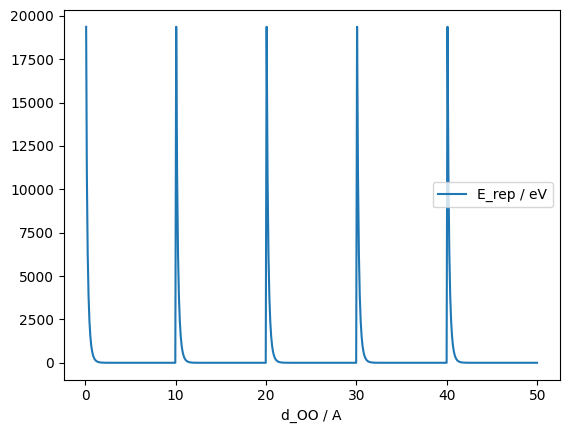

In [2]:
import pandas as pd

df = pd.read_csv("../data/20230425_repulsion_pbc_fix.csv")
df.plot(x="d_OO / A", y="E_rep / eV")

Wait ... what? **Why does the repulsion energy look asymmetric?**

## Asymmetric peak issue

Turns out the PBC code above (also used in `dispersion.cpp`) wasn't all that well thought out and was causing weird behavior. To fix that I just copied the [Wiki solution](https://en.wikipedia.org/wiki/Periodic_boundary_conditions#(B)_Do_not_restrict_the_particle_coordinates) which I should've just done in the first place and now it works properly. **`dispersion.cpp` was changed as well!**

```C++
for (int j = 0; j < 3; j++) {
    // Adjust the O-O distance for the PBC's
    dr[j] = ra[iOm+j] - ra[iOn+j];
    if (pbc[j]) {
        dr[j] = fabs(dr[j]);
        dr[j] -= static_cast<int>(dr[j] * inv_a[j] +  0.5) * a[j];
    }
}
```

Here, `inv_a` was precalculated as `1/a` for performance reasons.

In [3]:
df = pd.read_csv("../data/20230425_repulsion_fix_wrapping.csv")
df.plot(x="d_OO / A", y="E_rep / eV")

<AxesSubplot:xlabel='d_OO / A'>

The peaks are properly symmetric now but seem to drop in intensity at larger distances. Why? Some tests:

1. The first peak always seems to be the largest and peaks get smaller for higher repetitions.

1. Behavior is not related to smooth cutoff (see below). Looks the same when the cutoff is bypassed.

**Could this simply be a truncation error because values are so large?**

**Test:** The test input (see above) leads to a full and complete overlap of the water molecules, leading to huge repulsive forces. By repeating the same test with one molecule slightly offset, we can reduce the absolute magnitude of the forces.

Result:

<AxesSubplot:xlabel='d_OO / A'>

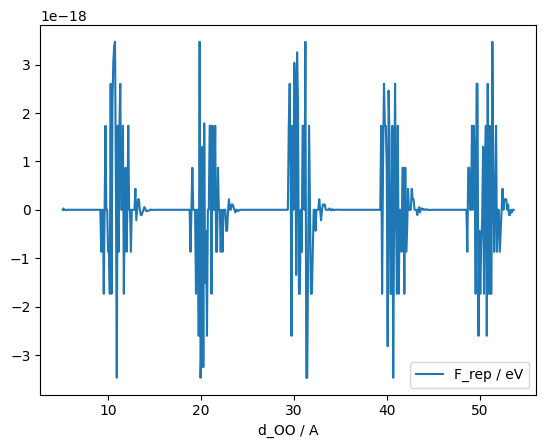

In [7]:
df = pd.read_csv("../data/20230426_repulsion_validation.csv")
df.plot(x="d_OO / A", y="E_rep / eV")
df.plot(x="d_OO / A", y="F_rep / eV")

Looks fine now, so the issue was likely truncation of too large values. The forces also suffer from truncation issues as well but in the other direction since we're operating at values almost beyond double precision.

## Introducing a smooth cutoff

Similar to `dispersion.cpp`, the repulsion energy and forces should be subject to a smooth cutoff function which smoothly interpolates to zero between a cutoff onset $r_\mathrm{o}$ and the hard cutoff $r_\mathrm{c}$. 

$r_\mathrm{c} = 3.3$ and $r_\mathrm{o} = 0.66 \cdot r_\mathrm{c}$ will be chosen for the moment because at 3.3 A, the repulsion energy has fallen below 0.05 eV, *i.e.*, chemical accuracy (*ca.* 1 kcal/mol).

<AxesSubplot:xlabel='d_OO / A'>

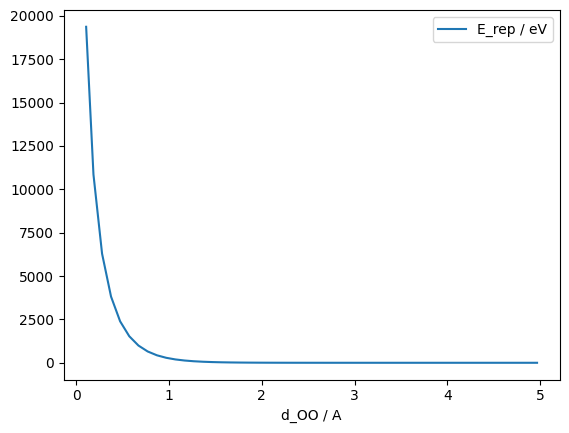

In [5]:
df = pd.read_csv("../data/20230425_repulsion_original.csv")
df.plot(x="d_OO / A", y="E_rep / eV")

To this end, we import `cutoff_function` and `d_cutoff_function` from `dispersion.cpp`.

The code for the evaluation of energy and forces now reads:

```C++
[...]
uCore += fcutoff * t1;

df = (Ar*(br/r+cr)*t13*t11) / r;
df = fcutoff * df + 2 * dfcutoff * t1;

for (int i = 0; i < 3; i++) {
    fa[iOn + i] += df*dr[i];
    fa[iOm + i] -= df*dr[i];
}
[...]
``` 

Note that `fcutoff` is not applied directly to `t1` (pairwise energy) because we need the undampened `t1` below for the smooth cutoff of the derivative / forces.

Comparison of the repulsion energy as a function of the O-O separation distance of a water dimer:

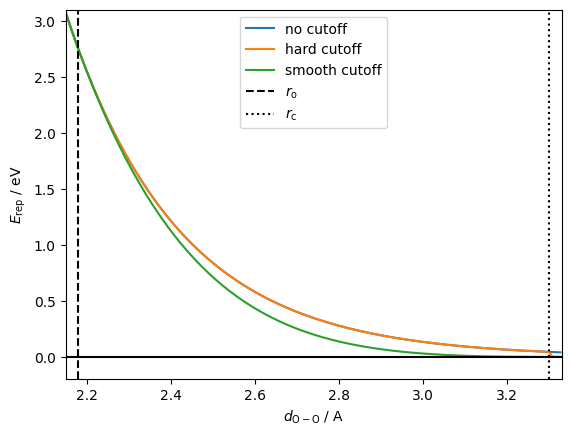

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)

# Read in data.
df_norc = pd.read_csv("../data/20230425_repulsion_no_cutoff.csv")
df_hard = pd.read_csv("../data/20230425_repulsion_hard_cutoff.csv")
df_soft = pd.read_csv("../data/20230425_repulsion_smooth_cutoff.csv")

# Plot various data.
df_norc.plot(x="d_OO / A", y="E_rep / eV", ax=ax, label="no cutoff")
df_hard.plot(x="d_OO / A", y="E_rep / eV", ax=ax, label="hard cutoff")
df_soft.plot(x="d_OO / A", y="E_rep / eV", ax=ax, label="smooth cutoff")

# Add extra lines to indicate r_o, r_c.
plt.axhline(y=0, color="black")
plt.axvline(x=2.18, color="black", linestyle="--", label="$r_\mathrm{o}$")
plt.axvline(x=3.3, color="black", linestyle=":", label="$r_\mathrm{c}$")
ax.set_xlabel("$d_\mathrm{O-O}$ / A")
ax.set_ylabel("$E_\mathrm{rep}$ / eV")

# Plot settings.
plt.ylim([-0.2,3.1])
plt.xlim([2.15,3.33])
plt.legend()
plt.show()

## Passing and checking for Tags

Similar to the approach for `dispersion.cpp`, we pass a `tags` boolean array to `coreInt.cpp` which identifies every atom as QM (`True`) or MM (`False`). In the main loop, we make sure that the repulsive interactions are only calculated for QM-MM and MM-MM pairs since the QM calculator adds this contribution for QM-QM pairs.

```C++
// Only evaluate MM-MM and QM-MM pairs, skip QM-QM.
if (tags[n] && tags[m]) {
    continue;
}
```